In [1]:
import kagglehub
import pandas as pd
import numpy as np
 # Download latest version
path = kagglehub.dataset_download("wenruliu/adult-income-dataset")

print("Path to dataset files:", path)

c:\Users\Usuario\Downloads\Automações\Privacidade_Diferencial\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\Usuario\.cache\kagglehub\datasets\wenruliu\adult-income-dataset\versions\2


In [2]:
df = pd.read_csv(fr'{path}\adult.csv')

def prepocessing(df):

    df.drop(columns=['fnlwgt', 'education', 'capital-gain', 'capital-loss', 'hours-per-week'], inplace = True)

    fill_rows = ~(df == '?').any(axis = 1)
    df = df[fill_rows]

    for col in df.columns:
        if df[col].dtype == 'object' or pd.api.types.is_categorical_dtype(df[col]):
          df[col], _ = pd.factorize(df[col])

    return df

def split_train_test(df, test_size=0.3):
    # 1. Embaralha o DataFrame inteiro aleatoriamente
    shuffled_df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    # 2. Calcula o ponto de corte
    len_df = len(shuffled_df)
    cut_point = len_df - round(len_df * test_size)

    # 3. Divide o DataFrame embaralhado
    train = shuffled_df[:cut_point]
    test = shuffled_df[cut_point:]

    print(f'Tamanho total: {len(df)}')
    print(f'Tamanho do treino: {len(train)}')
    print(f'Tamanho do teste: {len(test)}')

    return train, test

df = prepocessing(df)
X_train, X_test = split_train_test(df)

Tamanho total: 45222
Tamanho do treino: 31655
Tamanho do teste: 13567


C:\Users\Usuario\AppData\Local\Temp\ipykernel_16400\2645425365.py:11: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if df[col].dtype == 'object' or pd.api.types.is_categorical_dtype(df[col]):
C:\Users\Usuario\AppData\Local\Temp\ipykernel_16400\2645425365.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col], _ = pd.factorize(df[col])
C:\Users\Usuario\AppData\Local\Temp\ipykernel_16400\2645425365.py:11: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if df[col].dtype == 'object' or pd.api.types.is_categorical_dtype(df[col]):
C:\Users\Usuari

In [3]:
import numpy as np
import pandas as pd
import time

class KNN_DP():
    def __init__(self, k):
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = np.array(X, dtype=np.float32)
        self.y_train = np.array(y)

    def get_vizinhos_indices_vectorized(self, test_row):
            
        diferencas = self.X_train - test_row
        
        # Soma dos quadrados (distância euclidiana ao quadrado é suficiente para ordenar)
        dist_sq = np.sum(diferencas**2, axis=1)
        

        indices = np.argpartition(dist_sq, self.k)[:self.k]
        
        return indices

    def predict_instance(self, test_row):
        # Busca índices rápidos
        indices = self.get_vizinhos_indices_vectorized(test_row)
        classes_vizinhas = self.y_train[indices]

        # Votação majoritária simples
        valores, contagens = np.unique(classes_vizinhas, return_counts=True)
        indice_vencedor = np.argmax(contagens)
        return valores[indice_vencedor]

    def predict_instance_private(self, test_row, epsilon):
        # Busca índices rápidos
        indices = self.get_vizinhos_indices_vectorized(test_row)
        classes_vizinhas = self.y_train[indices]

        # Obtém as classes possíveis (assume-se que y_train tem todas as classes)
        # Para otimizar, poderiamos salvar unique(y_train) no fit, mas ok fazer aqui.
        valores_unicos = np.unique(self.y_train)

        # Dicionário de contagem inicializado com 0
        contagens = {val: 0 for val in valores_unicos}

        # Contagem real dos vizinhos
        for cls in classes_vizinhas:
            contagens[cls] += 1

        # Mecanismo de Laplace
        # Sensibilidade = 1, Scale = 1/epsilon
        scale = 1.0 / epsilon

        melhor_classe = None
        maior_voto_ruidoso = -float('inf')

        for cls in contagens:
            ruido = np.random.laplace(loc=0.0, scale=scale)
            voto_ruidoso = contagens[cls] + ruido

            if voto_ruidoso > maior_voto_ruidoso:
                maior_voto_ruidoso = voto_ruidoso
                melhor_classe = cls

        return melhor_classe

    def predict(self, X_test):
        X_test = np.array(X_test, dtype=np.float32)
        predicoes = []
        total = len(X_test)
        
        print("Iniciando predição padrão...")
        for i, row in enumerate(X_test):
            pred = self.predict_instance(row)
            predicoes.append(pred)
            if i % 1000 == 0: # Log de progresso
                print(f"Progresso: {i}/{total}", end='\r')
                
        return np.array(predicoes)

    def predict_private(self, X_test, epsilon):
        X_test = np.array(X_test, dtype=np.float32)
        predicoes = []
        total = len(X_test)
        
        print(f"Iniciando predição privada (eps={epsilon})...")
        for i, row in enumerate(X_test):
            pred = self.predict_instance_private(row, epsilon)
            predicoes.append(pred)
            if i % 1000 == 0:
                print(f"Progresso: {i}/{total}", end='\r')
                
        return np.array(predicoes)

# ---------------------------------------------------
# CORREÇÃO DAS VARIÁVEIS NO SCRIPT DE EXECUÇÃO
# ---------------------------------------------------

# 1. Preparação correta dos dados
# .values garante que seja array numpy, evitando índices do pandas
y_train = X_train['age'].values
x_train = X_train.drop(columns=['age']).values

y_test = X_test['age'].values
x_test = X_test.drop(columns=['age']).values # <-- ISSO É O IMPORTANTE

k = 10
model = KNN_DP(k=k)

# Treinamento
print("Treinando modelo...")
model.fit(x_train, y_train)

# 1. Execução KNN Tradicional
print("Executando KNN Tradicional...")

# ERRO ESTAVA AQUI: Você passava X_test (com age) ao invés de x_test (sem age)
y_pred_padrao = model.predict(x_test) 

# Salvando resultado tradicional
df_resultado = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred_padrao
})
df_resultado.to_csv('resultado_knn_tradicional.csv', index=False)
print("\nResultado Tradicional salvo.")

# 2. Execução KNN Privado para diferentes epsilons
epsilons = [0.5, 1, 1.5]

for eps in epsilons:
    print(f"\nExecutando KNN Privado (epsilon={eps})...")
    
    y_pred_privado = model.predict_private(x_test, epsilon=eps)

    # Salvando resultado privado
    nome_arquivo = f'resultado_knn_laplace_eps_{eps}.csv'
    df_resultado_priv = pd.DataFrame({
        'y_true': y_test,
        'y_pred': y_pred_privado
    })
    df_resultado_priv.to_csv(nome_arquivo, index=False)
    print(f"\nArquivo {nome_arquivo} salvo.")

print("Processo finalizado.")

Treinando modelo...
Executando KNN Tradicional...
Iniciando predição padrão...
Progresso: 13000/13567
Resultado Tradicional salvo.

Executando KNN Privado (epsilon=0.5)...
Iniciando predição privada (eps=0.5)...
Progresso: 13000/13567
Arquivo resultado_knn_laplace_eps_0.5.csv salvo.

Executando KNN Privado (epsilon=1)...
Iniciando predição privada (eps=1)...
Progresso: 13000/13567
Arquivo resultado_knn_laplace_eps_1.csv salvo.

Executando KNN Privado (epsilon=1.5)...
Iniciando predição privada (eps=1.5)...
Progresso: 13000/13567
Arquivo resultado_knn_laplace_eps_1.5.csv salvo.
Processo finalizado.


In [4]:
def acuracia(pred, y_target):
    return  sum(pred == y_target)/len(y_target)

df = pd.read_csv('resultado_knn_tradicional.csv')
acr = acuracia(df['y_pred'].values, df['y_true'].values)
print(f'Acurácia dataset original: {acr}')

print(f"Resultado datasets...")

epsilons = [0.5, 1, 1.5]
for eps in epsilons:
    
     # Salvando resultado privado
    df_epsilon = pd.read_csv(f'resultado_knn_laplace_eps_{eps}.csv')
    acr = acuracia(df_epsilon['y_pred'].values, df_epsilon['y_true'].values)
    print(f'Acurácia dataset ε={eps}: {acr}')

print("Processo finalizado.")

Acurácia dataset original: 0.05248028303972875
Resultado datasets...
Acurácia dataset ε=0.5: 0.01724773347092209
Acurácia dataset ε=1: 0.027861723299181837
Acurácia dataset ε=1.5: 0.0358959239330729
Processo finalizado.


Acurácia Tradicional: 0.0525
Acurácia (eps=0.5): 0.0172
Acurácia (eps=1): 0.0279
Acurácia (eps=1.5): 0.0359


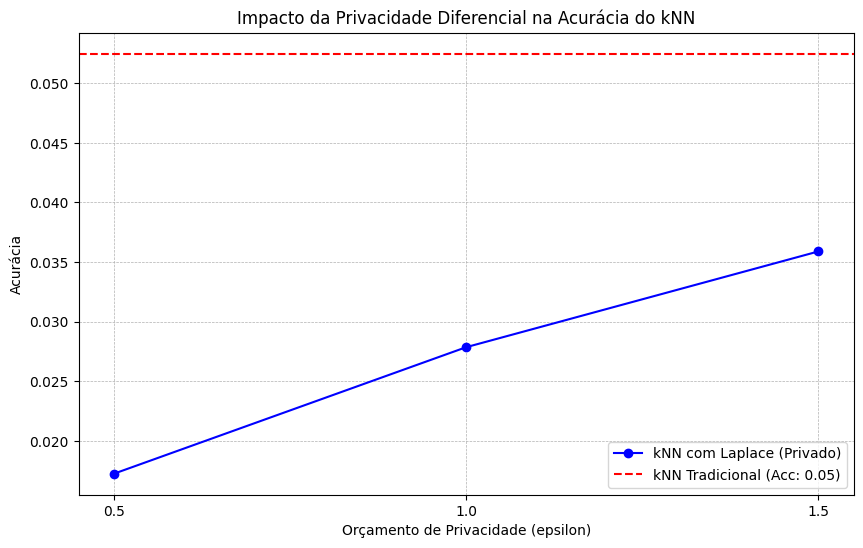

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Definição dos epsilons usados
epsilons = [0.5, 1, 1.5]

# Lista para armazenar as acurácias
acuracias_privadas = []

# 1. Calcular Acurácia do kNN Tradicional (Baseline)
# Certifique-se que o arquivo existe
df_trad = pd.read_csv('resultado_knn_tradicional.csv')
acc_tradicional = acuracia(df_trad['y_true'], df_trad['y_pred'])
print(f"Acurácia Tradicional: {acc_tradicional:.4f}")

# 2. Calcular Acurácias dos Privados
for eps in epsilons:
    filename = f'resultado_knn_laplace_eps_{eps}.csv'
    if os.path.exists(filename):
        df_priv = pd.read_csv(filename)
        acc = acuracia(df_priv['y_true'], df_priv['y_pred'])
        acuracias_privadas.append(acc)
        print(f"Acurácia (eps={eps}): {acc:.4f}")
    else:
        print(f"Arquivo {filename} não encontrado!")
        acuracias_privadas.append(0) # Valor dummy se faltar arquivo

# 3. Gerar o Gráfico
plt.figure(figsize=(10, 6))

# Linha da privacidade diferencial
plt.plot(epsilons, acuracias_privadas, marker='o', linestyle='-', color='b', label='kNN com Laplace (Privado)')

# Linha de referência (kNN sem privacidade)
# Plotamos uma linha horizontal constante
plt.axhline(y=acc_tradicional, color='r', linestyle='--', label=f'kNN Tradicional (Acc: {acc_tradicional:.2f})')

# Estilização
plt.title('Impacto da Privacidade Diferencial na Acurácia do kNN')
plt.xlabel('Orçamento de Privacidade (epsilon)')
plt.ylabel('Acurácia')
plt.xticks(epsilons) # Garante que mostre apenas os epsilons do teste no eixo X
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

# Salvar ou mostrar
plt.savefig('grafico_acuracia_epsilon.png')
plt.show()

In [6]:
class MecanismoLaplace:

    def __init__(self, epsilon):
        # Guarda o orçamento total de privacidade definido pelo usuário.
        self.epsilon = epsilon
    "Função que pega um valor real (contagem de vizinhos) e adiciona um valor aleatório (ruído)."
    def adicionar_ruido(self, valor_real, sensibilidade, num_classes):

        # Divisão do orçamento
        epsilon_fracionado = self.epsilon / num_classes
        #Calculo da escala
        escala = sensibilidade / epsilon_fracionado

        #Gera um ruido aleatorio, com média do ruído zero e definindo a dispersão do ruído como a escala
        ruido = np.random.laplace(loc=0.0, scale=escala)

        # Retorna a soma do valor original com o ruído gerado.
        return valor_real + ruido

#Implementa o algoritmo de vizinhos no raio
class ClassificadorRaioPrivado:

    def __init__(self, raio=6.0):
        # Define a distância máxima para considerar um ponto como vizinho.
        self.raio = raio

        # Variáveis para guardar os dados de treino.
        self.X_treino = None
        self.y_treino = None
        self.classes_unicas = None

    def treinar(self, X, y):
        # Converte a lista de características de x e y para um array NumPy.
        self.X_treino = np.array(X)
        self.y_treino = np.array(y)

        #Pega apenas a lista de classes distintas
        self.classes_unicas = np.unique(self.y_treino)

    def distancia_euclidiana(self, linha1, linha2):

        #Calcular a distancia entre duas coordenadas
        diferenca = linha1 - linha2

        #Calcula da distancia usando Pitágoras
        distancia = np.sqrt(np.sum(diferenca**2))

        # Retorna a distância.
        return distancia

    #Busca os vizinhos proximos
    def obter_vizinhos_no_raio(self, linha_teste):

        # Lista para guardar as classes dos vizinhos encontrados.
        vizinhos_encontrados = []

        # Loop que passa por cada linha da base de treinamento.
        for i in range(len(self.X_treino)):

            # Calcula a distância entre o ponto de teste atual e o ponto de treino i.
            dist = self.distancia_euclidiana(linha_teste, self.X_treino[i])

            # Verifica se a distância é menor ou igual ao raio 6.
            if dist <= self.raio:
                # Se estiver dentro do raio, adicionamos a classe desse vizinho na lista.
                vizinhos_encontrados.append(self.y_treino[i])

        # Retorna a lista com as classes de todos os vizinhos próximos.
        return vizinhos_encontrados

    #Faz a classificação
    def prever_instancia_privada(self, linha_teste, epsilon):

        # Chama a função interna para pegar as classes de quem está perto.
        lista_classes_vizinhas = self.obter_vizinhos_no_raio(linha_teste)

        # Cria um dicionário com todas as classes possíveis iniciando com 0 votos.
        contagens_reais = {classe: 0 for classe in self.classes_unicas}

        # Conta quantos vizinhos existem para cada classe.
        for classe_vizinha in lista_classes_vizinhas:
            # Incrementa o contador daquela classe.
            contagens_reais[classe_vizinha] += 1

        # Instancia a nossa classe de ruído com o epsilon fornecido.
        mecanismo = MecanismoLaplace(epsilon)

        # Verifica quantas classes existem no total para dividir o epsilon.
        total_classes = len(self.classes_unicas)

        # Dicionário para guardar os votos com ruído.
        contagens_ruidosas = {}

        # Loop para aplicar ruído em TODAS as classes possíveis, mesmo se a classe teve voto 0
        for classe in self.classes_unicas:
            # Pega a contagem verdadeira.
            valor_verdadeiro = contagens_reais[classe]

            # Chama a função que adiciona o ruído de Laplace, definindo a sensibilidade como 1.
            valor_com_ruido = mecanismo.adicionar_ruido(
                valor_real=valor_verdadeiro,
                sensibilidade=1.0,
                num_classes=total_classes
            )

            # Guarda o valor ruidoso no dicionário.
            contagens_ruidosas[classe] = valor_com_ruido

        #Definir a melhor classe nos valores com ruído
        melhor_classe = None
        maior_valor_encontrado = -float('inf') # Inicializar com o menor valor possivel.

        # Varre o dicionário de contagens ruidosas para achar o maior valor.
        for classe, valor in contagens_ruidosas.items():
            # Se o valor atual for maior que o recorde anterior.
            if valor > maior_valor_encontrado:
                # Atualiza o recorde.
                maior_valor_encontrado = valor
                # Define essa classe como a vencedora.
                melhor_classe = classe

        # Retorna a classe que teve a maior contagem ruidosa.
        return melhor_classe
    #Recebe  os dados de teste e aplica a predição com base nos valores ruidosos
    def prever_privado(self, X_teste, epsilon):

        # Garante que X_teste seja um array numpy.
        X_teste = np.array(X_teste)

        # Lista para guardar todas as previsões.
        lista_predicoes = []

        # Loop que passa linha por linha da base de teste.
        for linha in X_teste:
            # Chama a função, que retorna a predição com base nos valores com ruído.
            predicao = self.prever_instancia_privada(linha, epsilon)

            # Adiciona o resultado na lista de predições.
            lista_predicoes.append(predicao)

        # Transforma a lista final em um array numpy e retorna.
        return np.array(lista_predicoes)



########Simulação###############
# ... (Mantenha as classes MecanismoLaplace e ClassificadorRaioPrivado aqui em cima) ...

######## Simulação com Mais Dados ###############
if __name__ == "__main__":

    # Define uma "semente" para os números aleatórios.
    # Isso garante que sempre que você rodar, os dados gerados serão os mesmos.
    np.random.seed(42)

    print("--- Gerando Dados Sintéticos ---")

    # 1. Gerando a Classe 0 (50 pontos ao redor de 2,2)
    # np.random.randn cria números numa curva normal. Somamos +2 para mover o centro.
    X_classe0 = np.random.randn(50, 2) + 2
    y_classe0 = [0] * 50 # Lista com 50 zeros

    # 2. Gerando a Classe 1 (50 pontos ao redor de 8,8)
    # Somamos +8 para mover o centro para longe da classe 0.
    X_classe1 = np.random.randn(50, 2) + 8
    y_classe1 = [1] * 50 # Lista com 50 uns

    # 3. Juntando tudo no conjunto de Treino
    # np.concatenate cola os arrays um embaixo do outro.
    X_treino = np.concatenate([X_classe0, X_classe1])
    y_treino = np.concatenate([y_classe0, y_classe1])

    print(f"Total de dados de treino: {len(X_treino)} linhas")

    # 4. Criando pontos de Teste Estratégicos
    dados_teste = [
        [2, 2],   # Ponto bem no meio da Classe 0 (Deveria ser 0)
        [8, 8],   # Ponto bem no meio da Classe 1 (Deveria ser 1)
        [5, 5],   # Ponto no "limbo" entre os dois (Dúvida cruel)
        [10, 10], # Ponto extremo da Classe 1 (Deveria ser 1)
        [0, 0]    # Ponto extremo da Classe 0 (Deveria ser 0)
    ]

    print(f"Dados de teste: {dados_teste}")
    print("-" * 30)

    # 5. Instancia e Treina o Modelo
    # Raio 6.0 é grande o suficiente para pegar bastante gente nesse cenário
    modelo = ClassificadorRaioPrivado(raio=6.0)
    modelo.treinar(X_treino, y_treino)

    # 6. Testando com diferentes Epsilons (Orçamentos de Privacidade)
    lista_epsilons = [0.1, 1.0, 10.0]

    for eps in lista_epsilons:
        print(f"\n>>> Testando com Epsilon = {eps}")

        if eps == 0.1:
            print("(Muita Privacidade / Muito Ruído -> Esperamos erros)")
        elif eps == 10.0:
            print("(Pouca Privacidade / Pouco Ruído -> Esperamos precisão)")

        # Faz a predição
        predicoes = modelo.prever_privado(dados_teste, epsilon=eps)

        # Mostra o resultado lado a lado
        for i, ponto in enumerate(dados_teste):
            print(f"Ponto {ponto} -> Classificado como: {predicoes[i]}")

--- Gerando Dados Sintéticos ---
Total de dados de treino: 100 linhas
Dados de teste: [[2, 2], [8, 8], [5, 5], [10, 10], [0, 0]]
------------------------------

>>> Testando com Epsilon = 0.1
(Muita Privacidade / Muito Ruído -> Esperamos erros)
Ponto [2, 2] -> Classificado como: 0
Ponto [8, 8] -> Classificado como: 1
Ponto [5, 5] -> Classificado como: 0
Ponto [10, 10] -> Classificado como: 1
Ponto [0, 0] -> Classificado como: 0

>>> Testando com Epsilon = 1.0
Ponto [2, 2] -> Classificado como: 0
Ponto [8, 8] -> Classificado como: 1
Ponto [5, 5] -> Classificado como: 0
Ponto [10, 10] -> Classificado como: 1
Ponto [0, 0] -> Classificado como: 0

>>> Testando com Epsilon = 10.0
(Pouca Privacidade / Pouco Ruído -> Esperamos precisão)
Ponto [2, 2] -> Classificado como: 0
Ponto [8, 8] -> Classificado como: 1
Ponto [5, 5] -> Classificado como: 0
Ponto [10, 10] -> Classificado como: 1
Ponto [0, 0] -> Classificado como: 0
